Let's first initialize the matrices and some variables

In [5]:
from generate_sparse_matrix import generate_sparse_matrix
from accesses_calculation import input_accesses_calculation
from accesses_calculation import output_accesses_calculation
from bandwidth_calculation import input_bandwidth_calculation
from bandwidth_calculation import output_bandwidth_calculation
from avg_reuse_distance import avg_reuse_distance
import math
import matplotlib.pyplot as plt
import numpy as np

# Matrix generation
In_data_size = 8  # has to be a multiple of 8 such that the memory locations are not segmented
Out_data_size = 24  # has to be a multiple of 8 such that the memory locations are not segmented

X_rows, X_columns, X_sparsity = 4, 4, 0.1  # X_columns = Y_rows
Y_rows, Y_columns, Y_sparsity = 4, 4, 0.1

X_elem_size, Y_elem_size = 2, 2

X = generate_sparse_matrix(X_rows, X_columns, X_sparsity, In_data_size)
Y = generate_sparse_matrix(Y_rows, Y_columns, Y_sparsity, In_data_size)
Z = [['0' * Out_data_size for _ in range(Y_columns)] for _ in range(X_rows)]

# initialization of vectors of data usage
X_offset_addr = []
Y_offset_addr = []
Z_offset_addr = []

latency = 0

# Number of tiles for X and Y
k_iters = math.ceil(X_columns / X_elem_size)
Y_column_blocks = math.ceil(Y_columns / Y_elem_size)

Now we simulate the calculation using this 3 nested loops; one along the rows of X, one along che column blocks of Y and one along both the column blocks of X and row blocks of Y; inside this three nested loops we have two other nested loops that just compute the result; once this has been done, the list of access patterns is updated

In [6]:
for X_row in range(X_rows):
    for tile in range(k_iters):

        start_X = tile * X_elem_size
        end_X = min(start_X + X_elem_size, X_columns)

        # Load tile of X
        X_tile = X[X_row][start_X:end_X]

        for Y_column_block in range(Y_column_blocks):

                start_Y = Y_column_block * Y_elem_size
                end_Y = min(start_Y + Y_elem_size, Y_columns)

                # Load tile of Y
                Y_tile = [Y[k][start_Y:end_Y] for k in range(start_X, end_X)]

                # Initialize output buffer
                out_buffer = Z[X_row][start_Y:end_Y]

                #region COMPUTING THE RESULT FOR THE SPECIFIC CYCLE

                # Multiply-accumulate
                for x_idx, x_bin in enumerate(X_tile):
                    x_val = int(x_bin, 2)
                    for y_idx in range(end_Y - start_Y):
                        y_val = int(Y_tile[x_idx][y_idx], 2)
                        acc = int(out_buffer[y_idx], 2)
                        acc += x_val * y_val
                        acc &= (1 << Out_data_size) - 1
                        out_buffer[y_idx] = format(acc, f'0{Out_data_size}b')

                #endregion

                # Store in Z
                Z[X_row][start_Y:end_Y] = out_buffer

                # region APPENDING DATA ITEMS INFORMATION

                # Offset addresses for the current cycle
                X_start_addr = (X_row * X_columns + tile * X_elem_size) * (In_data_size / 8)
                Y_start_addr = (Y_column_block * Y_elem_size * Y_rows + tile * X_elem_size) * (In_data_size / 8)
                Z_start_addr = (X_row * Y_columns + Y_column_block * Y_elem_size) * (Out_data_size / 8)

                # Load the addresses of the accessed elements of each matrix for this cycle
                cycle_X = [X_start_addr + i * (In_data_size / 8) for i in range(end_X - start_X)]
                cycle_Y = []
                for step in range(end_Y - start_Y):
                    base_offset = step * (Y_rows * (In_data_size / 8))
                    for offset in range(end_X - start_X):
                        cycle_Y.append(Y_start_addr + base_offset + offset * (In_data_size / 8))
                cycle_Z = [Z_start_addr + i * (Out_data_size / 8) for i in range(end_Y - start_Y)]

                # Add the cycle address information to the list
                X_offset_addr.append(cycle_X)
                Y_offset_addr.append(cycle_Y)
                Z_offset_addr.append(cycle_Z)

                latency += 1

                # endregion

# At the end as final step I add a stall for the first load cycle and the last store cycle where no computation is done

X_offset_addr = X_offset_addr + [[]] + [[]]
Y_offset_addr = Y_offset_addr + [[]] + [[]]
Z_offset_addr_fetch = Z_offset_addr + [[]] + [[]]
Z_offset_addr_store = [[]] + [[]] + Z_offset_addr

# Now I turn the list into the actual accesses to memory using a function

X_offset_addr = input_accesses_calculation(X_offset_addr)
Y_offset_addr = input_accesses_calculation(Y_offset_addr)
Z_offset_addr_fetch = input_accesses_calculation(Z_offset_addr_fetch)
Z_offset_addr_store = output_accesses_calculation(Z_offset_addr_store)

Now that the calculation is complete and we've gathered enough data we put everything together by calculating some figures of merit

In [7]:
# FINAL LATENCY CALCULATION

latency = latency + 2

# BANDWIDTH CALCULATION

Input_avg_bandwidth, Input_peak_bandwidth = input_bandwidth_calculation(X_offset_addr, Y_offset_addr, Z_offset_addr_fetch,
                                                                        In_data_size, Out_data_size, 1,
                                                                        -1)
Output_avg_bandwidth, Output_peak_bandwidth = output_bandwidth_calculation(Z_offset_addr_store, Out_data_size)

Combined_avg_bandwidth = Input_avg_bandwidth + Output_avg_bandwidth
Combined_peak_bandwidth = Input_peak_bandwidth + Output_peak_bandwidth

# REUSE DISTANCE CALCULATION

X_reuse_distance = 0
Y_reuse_distance = avg_reuse_distance(Y_offset_addr)
Z_reuse_distance = avg_reuse_distance(Z_offset_addr_store)

Now we print these figure of merit and plot the results

Reuse policy: X

Latency: 18.0 cycles
Average Input bandwidth: 11.0 Bytes/ cycle
Peak Input bandwidth: 12.0 Bytes/ cycle
Average Output bandwidth: 6.0 Bytes/ cycle
Peak Output bandwidth: 6.0 Bytes/ cycle
Average Combined bandwidth: 17.0 Bytes/ cycle
Peak Combined bandwidth: 18.0 Bytes/ cycle
X Reuse Distance (cycles): 0.0
Y Reuse Distance (cycles): 5.5
Z Reuse Distance (cycles): 1.0



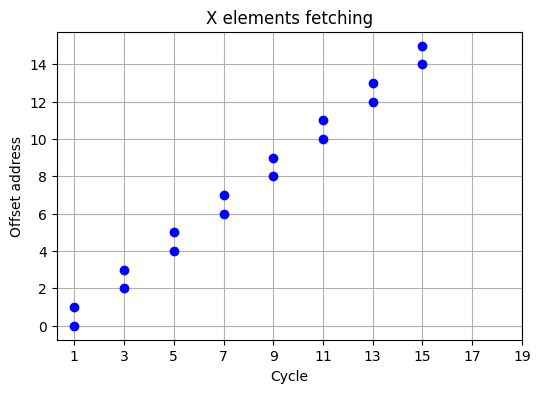

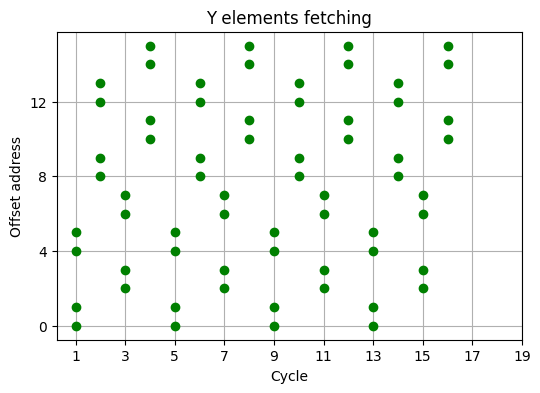

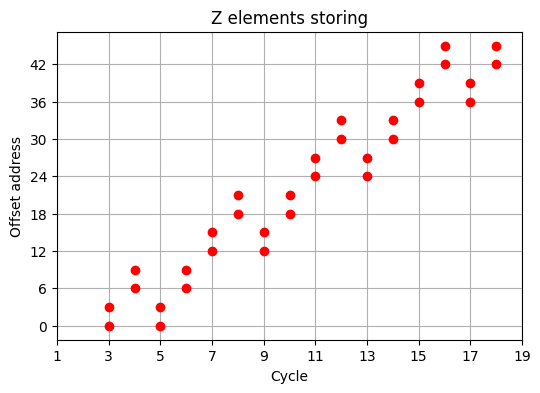

In [8]:
#region PRINTING AND DATA ITEMS PLOT

print("Reuse policy: X\n")
print(f"Latency: {latency:.1f} cycles")
print(f"Average Input bandwidth: {Input_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Input bandwidth: {Input_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Output bandwidth: {Output_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Output bandwidth: {Output_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Combined bandwidth: {Combined_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Combined bandwidth: {Combined_peak_bandwidth:.1f} Bytes/ cycle")
print(f"X Reuse Distance (cycles): {X_reuse_distance:.1f}")
print(f"Y Reuse Distance (cycles): {Y_reuse_distance:.1f}")
print(f"Z Reuse Distance (cycles): {Z_reuse_distance:.1f}\n")

indices = [(X_offset_addr, 'Offset address', 'X elements fetching', 'blue', 'o', X_elem_size,
            X_elem_size * (In_data_size / 8)),
            (Y_offset_addr, 'Offset address', 'Y elements fetching', 'green', 'o', Y_elem_size,
            (Y_rows * (In_data_size / 8))),
            (Z_offset_addr_store, 'Offset address', 'Z elements storing', 'red', 'o', X_elem_size,
            X_elem_size * (Out_data_size / 8))]

for vals, y_label, label, color, marker, x_spacing, y_spacing in indices:
    plt.figure(figsize=(6, 4))

    # Calculate x values based on the number of cycles (use the range of indices for x-axis)
    x = np.arange(1, len(vals) + 2)  # x will range from 1 to the number of cycles in vals

    for i, cycle in enumerate(vals):
        plt.plot([i + 1] * len(cycle), cycle, color=color, marker=marker, linestyle='None')

    plt.xlabel('Cycle')
    plt.ylabel(y_label)
    plt.title(f'{label}')

    # Set tick positions with customized offset and spacing for x-axis
    plt.xticks(np.arange(min(x), max(x) + 1, x_spacing))

    # Set tick positions for y-axis with custom offset and spacing
    flattened_vals = [item for sublist in vals for item in sublist]
    plt.yticks(np.arange(int(min(flattened_vals)), int(max(flattened_vals)) + 1, y_spacing))

    plt.grid(True)
    plt.show()

#endregion

Finally we print the actual results of the computation

In [9]:
print("Matrix X:")
for row in X:
    print(row)

print("\nMatrix Y:")
for row in Y:
    print(row)

print("\nResult Z:")
for row in Z:
    print(row)

Matrix X:
['00000000', '01101110', '11001000', '11000000']
['00010111', '01101011', '01111001', '00111010']
['00001100', '11011011', '01001100', '01110000']
['00010111', '11000001', '11110011', '00010011']

Matrix Y:
['00111010', '11100111', '00101110', '11100000']
['01110001', '01100101', '10110011', '01110010']
['00111111', '00000000', '00110001', '01111110']
['11100001', '11011001', '10001110', '11001010']

Result Z:
['000000010000101010000110', '000000001100111000100110', '000000001101110110110010', '000000010010101011101100']
['000000001000010100110010', '000000000111000000100010', '000000001000011001001000', '000000001010110100011000']
['000000001101100010000111', '000000001100000000101011', '000000001110011111110101', '000000001110100111001110']
['000000001010011011100111', '000000000111000100000001', '000000001100010000100010', '000000001111000010101010']
